In [85]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode,get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber,errors_bler
import matplotlib.pyplot as plt
import os
import math

In [95]:
n = 4
N = 2**n 
K = 9
snr = 1
batch_size = 1
num_samples = 1000


In [96]:

def create_data(num_samples, batch_size, n, K, snr,rs):
    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []

    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(batch_size, K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        polar = PolarCode(n, K, rs = rs, Fr=None, use_cuda=True, hard_decision=True)
        codeword = polar.encode(bpsk)
        corrupted_codewords = polar.channel(codeword, snr)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz"
    np.savez(f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz", msg_bits=msg_bits_list, corrupted_codeword=corrupted_codeword_list,bpsk = bpsk_list,codeword=codeword_list)
    print(f"Dataset saved as {filename}")
    

In [97]:
create_data(num_samples,batch_size,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N16_K9_SNR1_bs1.npz


In [98]:
df = np.load('data_rs\polar_dataset_N16_K9_SNR1_bs1.npz')

In [99]:
from tqdm.autonotebook import tqdm
Fr = get_frozen(N, K,rs=Reliability_Sequence)
polar = PolarCode(n, K, rs = Reliability_Sequence, Fr = Fr,use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
x=10000
for bpsk_bits, corrupted_codeword in tqdm(zip(df['bpsk'][:x], df['corrupted_codeword'][:x]),total=len(df['bpsk'][:x])):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device)
    corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32,device=device)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

100%|██████████| 1000/1000 [00:14<00:00, 68.84it/s]


In [100]:
ber_SC_total/len(df['msg_bits'][:x]),bler_SC_total/len(df['msg_bits'][:x])

(0.11277777976542712, 0.275)

### LSTM CCI

In [58]:
class LSTMDecoder(nn.Module):
    def __init__(self,N,K,hidden_size,rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), 0, dtype=torch.int8)
        # self.frozen_mask = torch.zeros(N,dtype=torch.bool)
        self.frozen_mask[self.frozen_positions] = 1
        self.lstms = nn.ModuleList([
            nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
            for _ in range(N)
        ])
        self.fcs= nn.ModuleList([
            nn.Linear(hidden_size, 1) for _ in range(N)
        ])
    
    def forward(self,corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]
        c0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]

        decoded_outputs = []
        for i in range(self.N):
            output, (h0[i], c0[i]) = self.lstms[i](x, (h0[i], c0[i]))

            decoded_bits = self.fcs[i](output).squeeze(-1)
            decoded_outputs.append(decoded_bits)
            x = corrupted_codeword + (self.frozen_mask.float().to(device)*decoded_bits.sign()) #current logic
            x = x.unsqueeze(-1)
        
        decoded_outputs = torch.stack(decoded_outputs,dim=1)
        # non_frozen_mask = ~self.frozen_mask
        non_frozen_mask = (self.frozen_mask == 0).nonzero(as_tuple=True)[0]

        final_predictions = decoded_outputs[:,-1,non_frozen_mask]

        return decoded_outputs, final_predictions


### LSTM augmented input

In [58]:
class LSTMDecoder2(nn.Module):
    def __init__(self,N,K,hidden_size,rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), 0, dtype=torch.int8)
        # self.frozen_mask = torch.zeros(N,dtype=torch.int8)
        self.frozen_mask[self.frozen_positions] = 1
        self.lstms = nn.ModuleList([
            nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
            for _ in range(N)
        ])
        self.fcs= nn.ModuleList([
            nn.Linear(hidden_size+1, 1) for _ in range(N) # 1 for the frozen bit
        ])
    
    def forward(self,corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]
        c0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]

        decoded_outputs = []
        for i in range(self.N):
            lstm_output, (h0[i], c0[i]) = self.lstms[i](x, (h0[i], c0[i]))

            frozen_bit = self.frozen_mask[i].float().to(device) 

            frozen_bit = frozen_bit.unsqueeze(0).unsqueeze(0).expand(batch_size, lstm_output.size(1), -1) 
         
            lstm_output_with_frozen = torch.cat([lstm_output, frozen_bit], dim=-1)

            predicted_bit = self.fcs[i](lstm_output_with_frozen).squeeze(-1)

            decoded_outputs.append(predicted_bit)
            # x = corrupted_codeword + (self.frozen_mask.float().to(device)*decoded_bits.sign()) #current logic
            x = torch.cat([x, predicted_bit.unsqueeze(-1)], dim=-1)[:,:,-1:]

        
        decoded_outputs = torch.stack(decoded_outputs,dim=1)
        # non_frozen_mask = ~self.frozen_mask
        non_frozen_mask = (self.frozen_mask == 0).nonzero(as_tuple=True)[0]

        final_predictions = decoded_outputs[:,-1,non_frozen_mask]

        return decoded_outputs, final_predictions

### Improved LSTM 

In [ ]:
#trying to learn the whole vector instead here
class ImprovedLSTMDecoder(nn.Module):
    def __init__(self, N, K, hidden_size, rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), -1, dtype=torch.int8)
        self.frozen_mask[self.frozen_positions] = 1

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=4)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.residual = nn.Linear(1, hidden_size * 2)

    def forward(self, corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = torch.zeros(2 * 2, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(2 * 2, batch_size, self.hidden_size, device=device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        
        lstm_out = self.layer_norm(lstm_out)

        # Attention mechanism
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_output = self.layer_norm(attn_output + lstm_out)

        # Residual connection
        residual = self.residual(x)
        attn_output = attn_output + residual

        decoded_bits = self.fc(attn_output).squeeze(-1)

        # Handle frozen bits
        decoded_bits[:, self.frozen_positions] = 0

        non_frozen_mask = (self.frozen_mask == -1).nonzero(as_tuple=True)[0]
        return decoded_bits[:, non_frozen_mask]


### Custom decoder


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PolarDecoder(nn.Module):
    def __init__(self, N, K, dec_hidden_size=64, activation='gelu'):
        super(PolarDecoder, self).__init__()
        self.N = N  # Block length
        self.K = K  # Number of information bits

        # Neural network for decoding
        self.decoder_nn = nn.Sequential(
            nn.Linear(N, dec_hidden_size),
            nn.ReLU() if activation == 'relu' else nn.GELU(),
            nn.Linear(dec_hidden_size, K)
        )

    def forward(self, noisy_codewords):
        """
        Decode the noisy codewords using a neural network.
        
        Args:
            noisy_codewords (torch.Tensor): The noisy codewords of shape (batch_size, N).
        
        Returns:
            torch.Tensor: Decoded information bits of shape (batch_size, K).
        """
        # Pass the noisy codewords through the neural network
        decoded_bits = self.decoder_nn(noisy_codewords)
        return decoded_bits


### CRISP

In [77]:
class RNN_Model(nn.Module):
    def __init__(self, rnn_type, input_size, feature_size, output_size, num_rnn_layers, y_size, y_hidden_size, y_depth, activation='relu', dropout=0., skip=False, out_linear_depth=1, y_output_size=None, bidirectional=False, use_layernorm=False):
        super(RNN_Model, self).__init__()

        assert rnn_type in ['GRU', 'LSTM']
        self.input_size = input_size
        self.activation = activation
        self.feature_size = feature_size
        self.output_size = output_size
        self.skip = skip

        self.num_rnn_layers = num_rnn_layers
        self.bidirectional = bidirectional
        self.rnn = getattr(nn, rnn_type)(self.input_size, self.feature_size, self.num_rnn_layers, bidirectional=self.bidirectional, batch_first=True)
        self.rnn_type = rnn_type
        self.dropout = dropout
        self.drop = nn.Dropout(dropout)

        self.y_depth = y_depth
        self.y_size = y_size
        self.y_hidden_size = y_hidden_size
        self.out_linear_depth = out_linear_depth
        self.y_output_size = (int(self.bidirectional) + 1) * self.num_rnn_layers * self.feature_size if y_output_size is None else y_output_size
        if use_layernorm:
            self.layernorm = nn.LayerNorm(self.feature_size)
        else:
            self.layernorm = nn.Identity()

        if self.y_hidden_size > 0 and self.y_depth > 0:
            self.y_linears = nn.ModuleList([nn.Linear(self.y_size, self.y_hidden_size, bias=True)])
            self.y_linears.extend([nn.Linear(self.y_hidden_size, self.y_hidden_size, bias=True) for ii in range(1, self.y_depth - 1)])
            if (not hasattr(self, 'skip')) or (not self.skip):
                self.y_linears.append(nn.Linear(self.y_hidden_size, self.y_output_size, bias=True))
            else:
                self.y_linears.append(nn.Linear(self.y_hidden_size, self.y_output_size - self.y_size, bias=True))

        if self.out_linear_depth == 1:
            self.linear = nn.Linear((int(self.bidirectional) + 1) * self.feature_size, self.output_size)
        else:
            layers = []
            layers.append(nn.Linear((int(self.bidirectional) + 1) * self.feature_size, self.y_hidden_size))
            for ii in range(1, self.out_linear_depth - 1):
                layers.append(nn.SELU())
                layers.append(nn.Linear(self.y_hidden_size, self.y_hidden_size))
            layers.append(nn.SELU())
            layers.append(nn.Linear(self.y_hidden_size, self.output_size))
            self.linear = nn.Sequential(*layers)

    def act(self, inputs):
        if self.activation == 'tanh':
            return F.tanh(inputs)
        elif self.activation == 'elu':
            return F.elu(inputs)
        elif self.activation == 'relu':
            return F.relu(inputs)
        elif self.activation == 'selu':
            return F.selu(inputs)
        elif self.activation == 'sigmoid':
            return F.sigmoid(inputs)
        elif self.activation == 'linear':
            return inputs
        else:
            return inputs

    def get_h0(self, y):
        x = y.clone()
        for ii, layer in enumerate(self.y_linears):
            if ii != self.y_depth:
                x = self.act(layer(x))
            else:
                x = layer(x)
        if self.skip:
            x = torch.cat([y, x], 1)
        x = x.reshape(-1, self.feature_size, (int(self.bidirectional) + 1) * self.num_rnn_layers).permute(2, 0, 1).contiguous()

        if self.rnn_type == 'GRU':
            return x
        else:
            return (x, x)

    def get_Fy(self, y):
        Fy = y.clone()
        for ii, layer in enumerate(self.y_linears):
            if ii != self.y_depth:
                Fy = self.act(layer(Fy))
            else:
                Fy = layer(Fy)
        return Fy

    def forward(self, input, hidden, Fy=None):
        out, hidden = self.rnn(input, hidden)
        out = self.drop(out)
        out = self.layernorm(out)

        if Fy is None:
            decoded = self.linear(out)
        else:
            decoded = self.linear(torch.cat([Fy, out], -1))
        decoded = decoded.view(-1, self.output_size)
        return decoded, hidden

In [80]:
rnn_type = 'LSTM'  # or 'LSTM'
input_size = 1  
feature_size = 256  # Hidden size of the RNN
output_size = 1  # Output size (e.g., 1 for binary classification)
num_rnn_layers = 2  # Number of RNN layers
y_size = 32  # Size of the input for the initial hidden state computation
y_hidden_size = 128  # Hidden size for the initial hidden state computation
y_depth = 3  # Depth of the initial hidden state computation network
activation = 'selu'  # Activation function
dropout = 0.1  # Dropout rate
skip = False  # Whether to use skip connections
out_linear_depth = 1  # Depth of the output linear layers
y_output_size = None  # Output size for the initial hidden state computation (optional)
bidirectional = False  # Whether to use bidirectional RNN
use_layernorm = False  # Whether to use layer normalization
device = 'cuda'
# Initialize the model
model = RNN_Model(
    rnn_type=rnn_type,
    input_size=input_size,
    feature_size=feature_size,
    output_size=output_size,
    num_rnn_layers=num_rnn_layers,
    y_size=y_size,
    y_hidden_size=y_hidden_size,
    y_depth=y_depth,
    activation=activation,
    dropout=dropout,
    skip=skip,
    out_linear_depth=out_linear_depth,
    y_output_size=y_output_size,
    bidirectional=bidirectional,
    use_layernorm=use_layernorm
).to(device)

### Training loop

In [81]:
class FocalLoss(nn.Module):
    """Focal Loss for handling imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # Ensure outputs are in probability space
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice_coeff

In [ ]:

device = 'cuda'
# model = LSTMDecoder(N=N, K=K, hidden_size=64, rs=Reliability_Sequence).to(device)
model = PolarDecoder(N,K,dec_hidden_size=64).to(device)
criterion = nn.BCEWithLogitsLoss()
focal_criterion = FocalLoss()
dice_criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [83]:
def calculate_ber_bler(predictions, targets):
    """ Calculate BER and BLER using errors_ber and errors_bler functions. """
    ber = errors_ber(targets, predictions.sign()).item()
    bler = errors_bler(targets, predictions.sign()).item()
    return ber, bler

In [ ]:
num_epochs = 50
patience = 5  # Early stopping patience
best_loss = float('inf')
trigger_times = 0

loss_values = []
ber_values = []
bler_values=[]
data_len = len(df['msg_bits'][:900])
for epoch in range(num_epochs):
    model.train()
    total_loss, total_ber, total_bler = 0, 0, 0

    for msg_bits, corrupted_codeword in tqdm(zip(df['msg_bits'][:900], df['corrupted_codeword'][:900]), total=data_len):
        msg_tensor = torch.tensor(msg_bits, dtype=torch.float32).to(device)
        corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)
        
                
        optimizer.zero_grad()
        final_predictions,_ = model(corrupted_codeword_tensor)
        # print(final_predictions.shape)
        bce_loss = criterion(final_predictions, msg_tensor)
        focal_loss = focal_criterion(final_predictions, msg_tensor)
        dice_loss = dice_criterion(final_predictions,msg_tensor)
        # loss = 20*focal_loss + dice_loss
        loss = bce_loss
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler((final_predictions >= 0).float(), msg_tensor)
        total_ber += ber
        total_bler += bler

    # Compute average loss and error rates
    avg_loss = total_loss / data_len
    avg_ber = total_ber / data_len
    avg_bler = total_bler / data_len

    loss_values.append(avg_loss)
    ber_values.append(avg_ber)
    bler_values.append(avg_bler)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
        
        ckpt_path = rf'weights_rs\N_{N}_K_{K}_SNR_{snr}_logic1_nonfrozen0_sign'
        os.makedirs(ckpt_path,exist_ok=True)
        torch.save(model.state_dict(), os.path.join(ckpt_path,f'epoch_{epoch}.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Logging progress every 3 epochs
    if (epoch + 1) % 3 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

print("Training complete.")



  0%|          | 0/900 [00:00<?, ?it/s]


TypeError: RNN_Model.forward() missing 1 required positional argument: 'hidden'

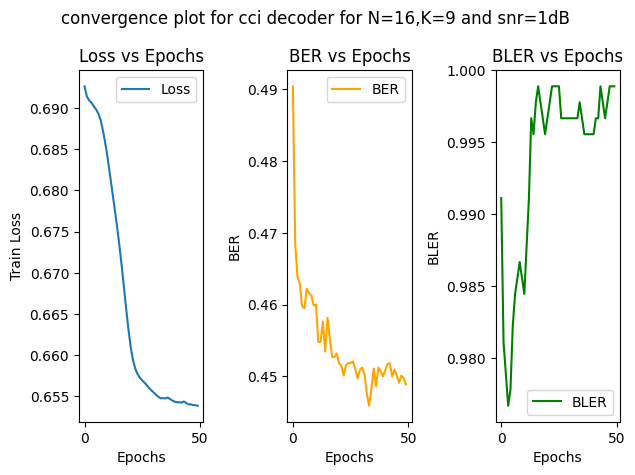

In [64]:
plt.suptitle('convergence plot for cci decoder for N=16,K=9 and snr=1dB')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(loss_values, label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(ber_values, label='BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(bler_values, label='BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
model.load_state_dict(torch.load(r'weights_rs\N_16_K_9_SNR_1_logic1_nonfrozen0_sign\epoch_29.pth'),strict=True)

<All keys matched successfully>

In [108]:
ber_total,bler_total = 0,0
test_loader = df['msg_bits'][900:]
count = 0
with torch.no_grad():
    model.eval()
    for msg_bits, corrupted_codeword in zip(df['msg_bits'][900:], df['corrupted_codeword'][900:]):
        count += 1
        msg_tensor = torch.tensor(msg_bits, dtype=torch.float32).to(device)
        corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)

        final_predictions = model(corrupted_codeword_tensor)
        if (count%20==0):
            print(f'final_predictions {(final_predictions>=0).float()}')
            print(f'msg_tensor {msg_tensor}')
            if((final_predictions>0).float()==msg_tensor).all():
                print('decoded correctly')
            else:
                print('decoded incorrectly')
            print('----------')
        ber,bler = calculate_ber_bler((final_predictions>=0).float(),msg_tensor)
        ber_total += ber
        bler_total += bler
    avg_ber = ber_total / len(test_loader)
    avg_bler = bler_total / len(test_loader)
    print(f"Test Results - BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

final_predictions tensor([[0., 1., 1., 1., 1., 1., 0., 1., 1.]], device='cuda:0')
msg_tensor tensor([[0., 1., 1., 0., 1., 0., 0., 1., 1.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[0., 1., 0., 0., 1., 0., 1., 0., 1.]], device='cuda:0')
msg_tensor tensor([[1., 1., 1., 1., 1., 0., 1., 0., 1.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 1., 0., 1., 0., 0., 0., 1., 1.]], device='cuda:0')
msg_tensor tensor([[0., 0., 0., 0., 0., 0., 1., 1., 1.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 1., 0., 0., 0., 0., 0., 1., 1.]], device='cuda:0')
msg_tensor tensor([[0., 1., 1., 0., 0., 0., 0., 1., 1.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 1., 1., 0., 1., 0., 1., 0., 1.]], device='cuda:0')
msg_tensor tensor([[0., 1., 0., 0., 1., 0., 1., 0., 1.]], device='cuda:0')
decoded incorrectly
----------
Test Results - BER: 0.3089, BLER: 0.9200
